In [109]:
!pip install xgboost

In [110]:
!pip install --upgrade xgboost

In [111]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor

In [112]:
coffee = pd.read_csv("CoffeeSales.csv")

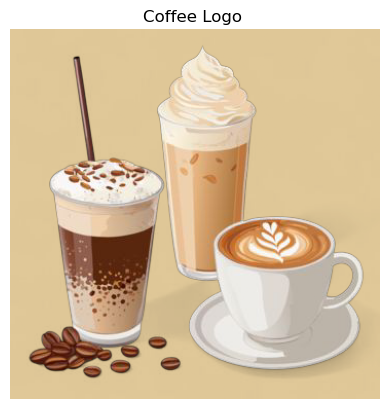

In [113]:
image_path = 'Coffee Logo.png'

if os.path.exists(image_path):
    # Load the image
    img = mpimg.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title('Coffee Logo ')
    plt.show()
else:
    print(f"Error: Image file not found at {image_path}")

In [114]:
coffee.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [115]:
# Rename the columns
coffee = coffee.rename(columns={
                                'date': 'Date',
                                'datetime': 'Datetime',
                                'cash_type': 'Cash_Type',
                                'card': 'Card_Name',
                                'money': 'Money',
                                'coffee_name': 'Coffee_Name'
                                })

In [116]:
coffee.isnull().sum()

Date            0
Datetime        0
Cash_Type       0
Card_Name      89
Money           0
Coffee_Name     0
dtype: int64

In [117]:
# Filling null values of card name as not provided
coffee['Card_Name'] = coffee['Card_Name'].fillna('Not Provided')

In [118]:
coffee.dtypes

Date            object
Datetime        object
Cash_Type       object
Card_Name       object
Money          float64
Coffee_Name     object
dtype: object

In [119]:
# Descriptive statistics for 'Money' column
coffee['Money'].describe()

count    1133.000000
mean       33.105808
std         5.035366
min        18.120000
25%        28.900000
50%        32.820000
75%        37.720000
max        40.000000
Name: Money, dtype: float64

In [120]:
# Drop the 'date' column
coffee = coffee.drop(columns=['Date'])

In [121]:
coffee['Datetime'] = pd.to_datetime(coffee['Datetime'])

In [122]:
coffee['Date_Only'] = coffee['Datetime'].dt.date
coffee['Hour'] = coffee['Datetime'].dt.hour
coffee['Day_of_Week'] = coffee['Datetime'].dt.day_name()
coffee['Month'] = coffee['Datetime'].dt.month_name()

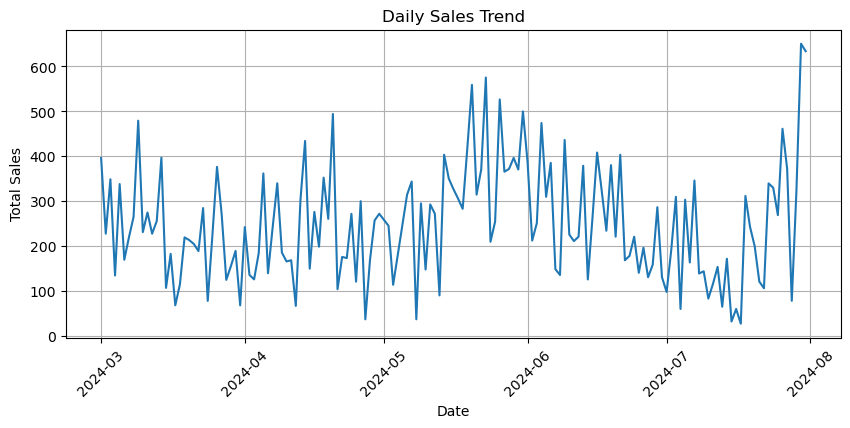

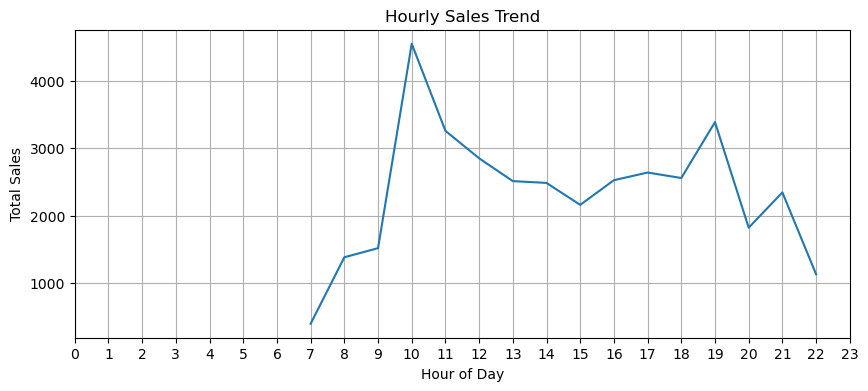

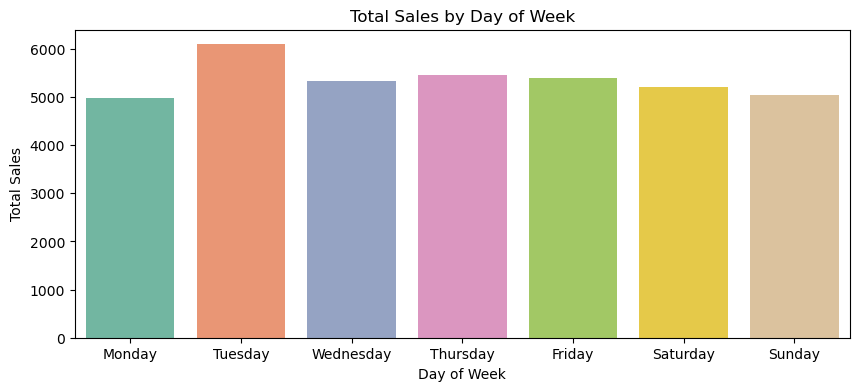

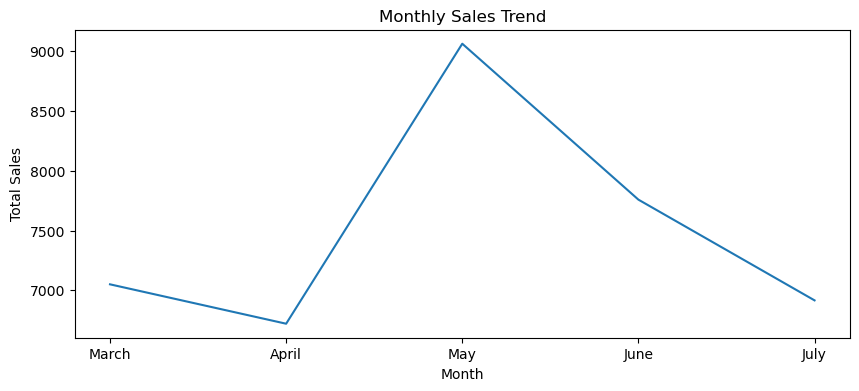

In [123]:
# Group by 'Date_Only' and calculate daily sales
daily_sales = coffee.groupby('Date_Only')['Money'].sum().reset_index()
daily_sales['Date_Only'] = pd.to_datetime(daily_sales['Date_Only'])
daily_sales = daily_sales.sort_values(by='Date_Only')

# Plot daily sales trend
plt.figure(figsize=(10 , 4))
sns.lineplot(data=daily_sales, x='Date_Only', y='Money')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout
plt.grid()
plt.show()

# Group by 'Hour' and calculate hourly sales
hourly_sales = coffee.groupby('Hour')['Money'].sum().reset_index()
hourly_sales = hourly_sales.sort_values(by='Hour')

# Plot hourly sales trend
plt.figure(figsize=(10 , 4))
sns.lineplot(data=hourly_sales, x='Hour', y='Money')
plt.title('Hourly Sales Trend')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

# Group by 'Day_of_Week' and calculate weekly sales
weekly_sales = coffee.groupby('Day_of_Week')['Money'].sum().reset_index()

# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex weekly_sales according to the defined order
weekly_sales['Day_of_Week'] = pd.Categorical(weekly_sales['Day_of_Week'], categories=day_order, ordered=True)
weekly_sales = weekly_sales.sort_values('Day_of_Week')


# Plot total sales by day of the week
plt.figure(figsize=(10 , 4))
sns.barplot(data=weekly_sales, x='Day_of_Week', y='Money', palette='Set2')
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.show()

# Group by 'Month' and calculate monthly sales
monthly_sales = coffee.groupby('Month')['Money'].sum().reset_index()

# Define the order of the months
month_order = ['March', 'April', 'May', 'June', 'July']

# Reindex monthly_sales according to the defined order
monthly_sales['Month'] = pd.Categorical(monthly_sales['Month'], categories=month_order, ordered=True)
monthly_sales = monthly_sales.sort_values('Month')

# Plot monthly sales trend
plt.figure(figsize=(10, 4))
sns.lineplot(data=monthly_sales, x='Month', y='Money')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


Distribution of Cash Types:
Cash_Type
card    1044
cash      89
Name: count, dtype: int64


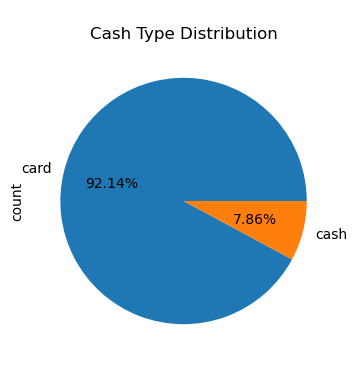

In [124]:
# Analyze the distribution of 'Cash_Type'
cash_type_counts = coffee['Cash_Type'].value_counts()

# Displaying the distribution
print("\nDistribution of Cash Types:")
print(cash_type_counts)

# Visualizing the distribution
plt.figure(figsize=(4,4))
cash_type_counts.plot(kind="pie",autopct='%.2f%%')
plt.title("\nCash Type Distribution")
plt.show()

In [125]:
# Displaying the unique coffee names
print("Different types of coffee available:")
print(coffee['Coffee_Name'].unique())

Different types of coffee available:
['Latte' 'Hot Chocolate' 'Americano' 'Americano with Milk' 'Cocoa'
 'Cortado' 'Espresso' 'Cappuccino']


In [126]:
# All coffee types ranked by sales count (from maximum to minimum)
ranked_coffee_sales = coffee['Coffee_Name'].value_counts()

print("Coffee types ranked by sales count (maximum to minimum):")
print(ranked_coffee_sales)

Coffee types ranked by sales count (maximum to minimum):
Coffee_Name
Americano with Milk    268
Latte                  243
Cappuccino             196
Americano              169
Cortado                 99
Hot Chocolate           74
Espresso                49
Cocoa                   35
Name: count, dtype: int64


Total Money Spent per Coffee Type:


Coffee_Name
Latte                  9009.14
Americano with Milk    8601.94
Cappuccino             7333.14
Americano              4644.54
Hot Chocolate          2778.48
Cortado                2745.08
Cocoa                  1295.94
Espresso               1100.62
Name: Money, dtype: float64

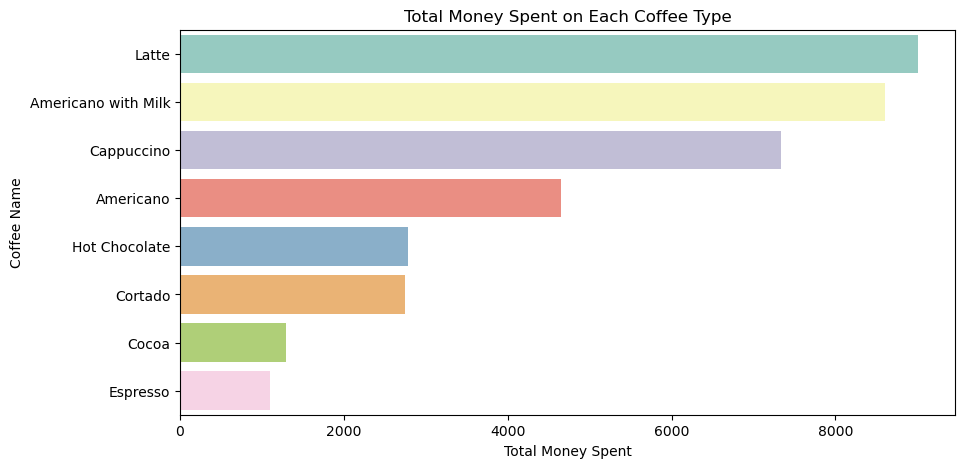

In [127]:
# Money spent on each coffee type
coffee_money_spent = coffee.groupby('Coffee_Name')['Money'].sum().sort_values(ascending=False)

# Displaying the result
print("Total Money Spent per Coffee Type:")
display(coffee_money_spent)

# Visualizing total money spent on each coffee type
plt.figure(figsize=(10, 5))
sns.barplot(x=coffee_money_spent.values, y=coffee_money_spent.index, palette='Set3')
plt.title('Total Money Spent on Each Coffee Type')
plt.xlabel('Total Money Spent')
plt.ylabel('Coffee Name')
plt.show()

Average Money Spent per Coffee Type:
Coffee_Name
Hot Chocolate          37.547027
Cappuccino             37.413980
Latte                  37.074650
Cocoa                  37.026857
Americano with Milk    32.096791
Cortado                27.728081
Americano              27.482485
Espresso               22.461633
Name: Money, dtype: float64


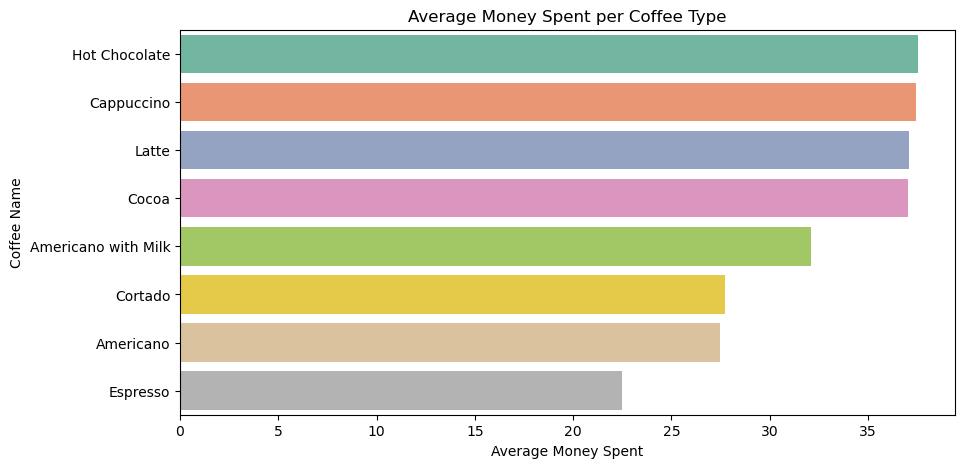

In [128]:
# Average money spent per coffee type
average_money_per_coffee = coffee.groupby('Coffee_Name')['Money'].mean().sort_values(ascending=False)

# Displaying the result
print("Average Money Spent per Coffee Type:")
print(average_money_per_coffee)

# Visualizing the average money spent per coffee type
plt.figure(figsize=(10 , 5))
sns.barplot(x=average_money_per_coffee.values, y=average_money_per_coffee.index, palette='Set2')
plt.title('Average Money Spent per Coffee Type')
plt.xlabel('Average Money Spent')
plt.ylabel('Coffee Name')
plt.show()

Average Money Spent for Top 3 Coffee Types:
Coffee_Name
Hot Chocolate    37.547027
Cappuccino       37.413980
Latte            37.074650
Name: Money, dtype: float64


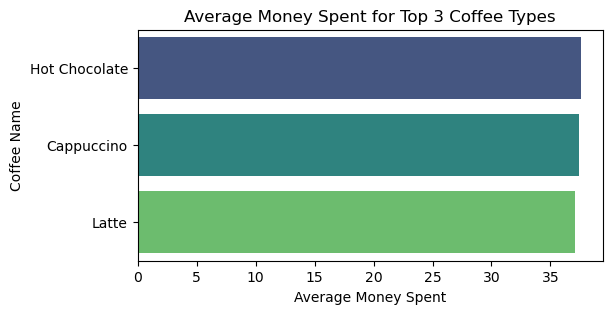

In [129]:
# Top 3 coffee types by average money spent
top_3_coffee_types = average_money_per_coffee.head(3)

# Displaying the result
print("Average Money Spent for Top 3 Coffee Types:")
print(top_3_coffee_types)

# Visualizing the top 3
plt.figure(figsize=(6, 3))
sns.barplot(x=top_3_coffee_types.values, y=top_3_coffee_types.index, palette='viridis')
plt.title('Average Money Spent for Top 3 Coffee Types')
plt.xlabel('Average Money Spent')
plt.ylabel('Coffee Name')
plt.show()

Customer Spending Patterns (Top 10 by Total Spent):


,total_money_spent,number_of_transactions
Card_Name,,
Not Provided,3186.00,89
ANON-0000-0000-0012,2593.18,88
ANON-0000-0000-0009,2212.70,63
ANON-0000-0000-0097,882.22,27
ANON-0000-0000-0040,706.36,22
ANON-0000-0000-0003,651.96,23
ANON-0000-0000-0001,646.14,17
ANON-0000-0000-0141,474.64,17
ANON-0000-0000-0180,442.84,12


None


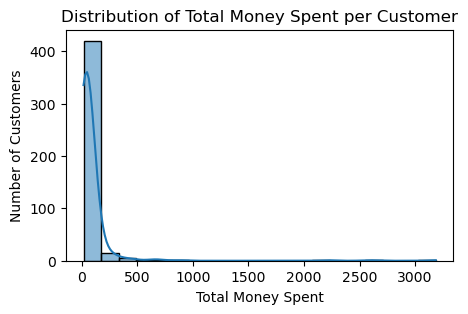

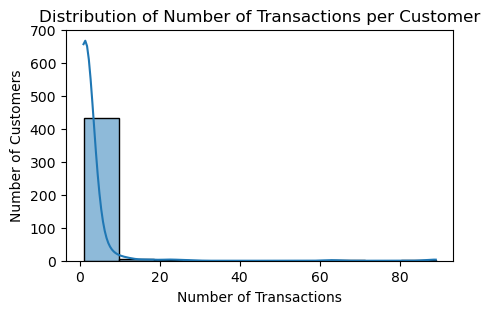

In [130]:
# Investigating individual customer spending patterns
# Grouping by 'Card_Name' and calculating total money spent and number of transactions
customer_spending = coffee.groupby('Card_Name').agg(
    total_money_spent=('Money', 'sum'),
    number_of_transactions=('Money', 'count')
).sort_values(by='total_money_spent', ascending=False)

# Displaying the first few rows of the customer spending data
print("Customer Spending Patterns (Top 10 by Total Spent):")
print(display(customer_spending.head(10)))

# Analyzing the distribution of total money spent per customer
plt.figure(figsize=(5 , 3))
sns.histplot(customer_spending['total_money_spent'], bins=20, kde=True)
plt.title('Distribution of Total Money Spent per Customer')
plt.xlabel('Total Money Spent')
plt.ylabel('Number of Customers')
plt.show()

# Analyzing the distribution of number of transactions per customer
plt.figure(figsize=(5, 3))
sns.histplot(customer_spending['number_of_transactions'], bins=10, kde=True)
plt.title('Distribution of Number of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [131]:
# List of unique card names
unique_card_names = customer_spending.index.tolist()

# Total number of unique card names
total_unique_card_names = len(unique_card_names)

# Displaying the total count
print(f"Total number of unique card names: {total_unique_card_names}")

Total number of unique card names: 447


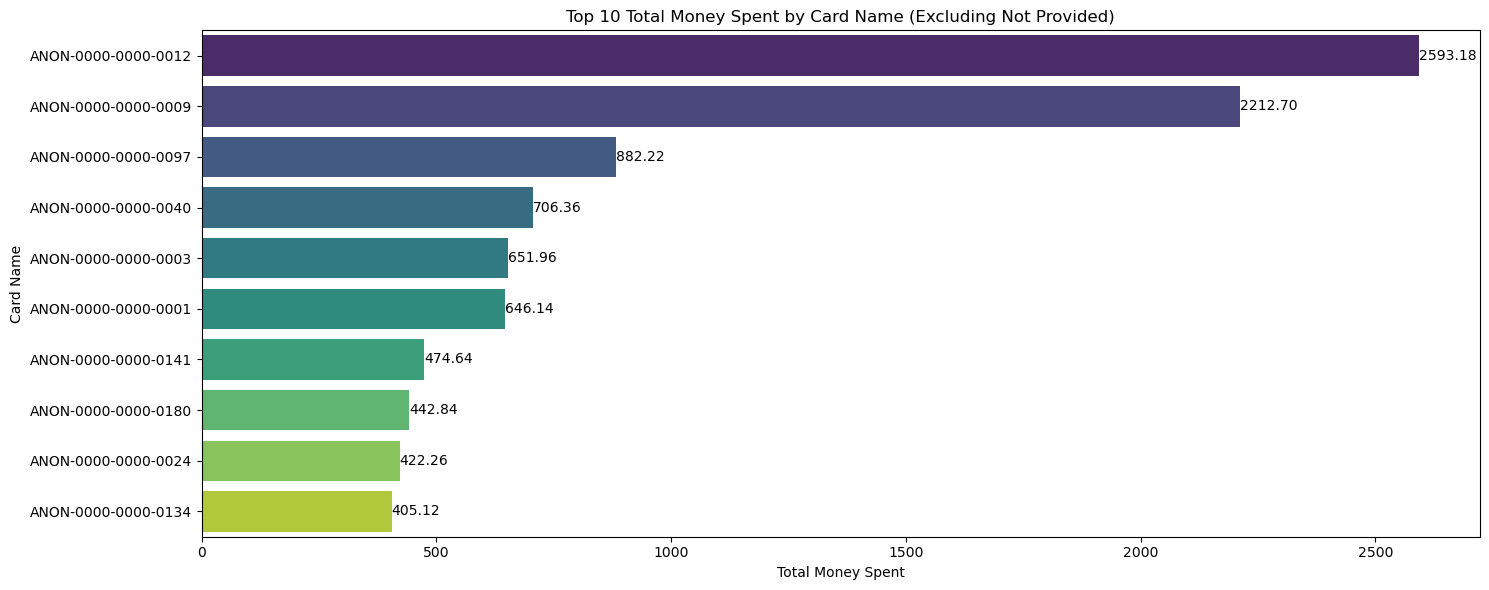

In [132]:
# Filtering out 'Not Provided' card names and get the top 10 card names by total money spent
top_10_customer_spending = customer_spending[customer_spending.index != 'Not Provided'].head(10)
top_10_card_names = top_10_customer_spending.index.tolist()

# Visualizing the highest to lowest spending card name
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=top_10_customer_spending['total_money_spent'], y=top_10_card_names, palette='viridis')
plt.title('Top 10 Total Money Spent by Card Name (Excluding Not Provided)')
plt.xlabel('Total Money Spent')
plt.ylabel('Card Name')
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

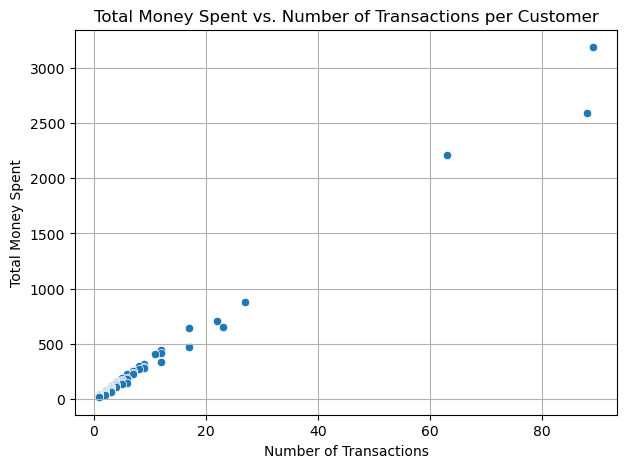

In [133]:
# Show a scatter plot of total money spent vs. number of transactions
plt.figure(figsize=(7, 5))
sns.scatterplot(data=customer_spending, x='number_of_transactions', y='total_money_spent')
plt.title('Total Money Spent vs. Number of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Money Spent')
plt.grid(True)
plt.show()

### Predicting whether customer will pay using Cash or Card

In [134]:
# Prepare target
coffee2 = coffee.copy()
coffee2['is_cash'] = (coffee2['Cash_Type'].str.lower().str.contains('cash')).astype(int)

# Basic features
coffee2['Hour'] = coffee2['Hour'].astype(int)
coffee2['dayofweek_num'] = coffee2['Datetime'].dt.weekday
coffee2['is_weekend'] = coffee2['dayofweek_num'].isin([5,6]).astype(int)
coffee2['Money'] = coffee2['Money'].astype(float)

# One-hot coffee name (or use target-encoding if many categories)
X = coffee2[['Hour','dayofweek_num','is_weekend','Money','Coffee_Name']].copy()
X = pd.get_dummies(X, columns=['Coffee_Name'], drop_first=True)
y = coffee2['is_cash']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# baseline model: logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

# stronger model: RandomForest
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       209
           1       0.00      0.00      0.00        18

    accuracy                           0.92       227
   macro avg       0.46      0.50      0.48       227
weighted avg       0.85      0.92      0.88       227

ROC-AUC: 0.8096757044125465
RF accuracy: 0.9691629955947136
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       209
           1       1.00      0.61      0.76        18

    accuracy                           0.97       227
   macro avg       0.98      0.81      0.87       227
weighted avg       0.97      0.97      0.97       227



### Coffee that is mostly liked by people

In [135]:
# 1. By count (most frequently ordered)
count_rank = coffee['Coffee_Name'].value_counts()
print("By count:")
print(count_rank.head())

# 2. By revenue (generates most revenue)
revenue_rank = coffee.groupby('Coffee_Name')['Money'].sum().sort_values(ascending=False)
print("By revenue:")
print(revenue_rank.head())

# 3. By repeat-buy rate (percentage of purchases by returning customers for that coffee (strong proxy for “liked”))
# create a dataset marking first purchase by card/customer per coffee
orders = coffee.copy()
orders['is_repeat'] = orders.duplicated(subset=['Card_Name','Coffee_Name'], keep='first').astype(int)
repeat_rate = 100*(orders.groupby('Coffee_Name')['is_repeat'].mean().sort_values(ascending=False))
print("By repeat rate (higher -> customers repurchase more):")
print(repeat_rate.head())


By count:
Coffee_Name
Americano with Milk    268
Latte                  243
Cappuccino             196
Americano              169
Cortado                 99
Name: count, dtype: int64
By revenue:
Coffee_Name
Latte                  9009.14
Americano with Milk    8601.94
Cappuccino             7333.14
Americano              4644.54
Hot Chocolate          2778.48
Name: Money, dtype: float64
By repeat rate (higher -> customers repurchase more):
Coffee_Name
Americano              59.763314
Americano with Milk    52.985075
Latte                  46.502058
Cappuccino             44.387755
Cortado                43.434343
Name: is_repeat, dtype: float64


### Predicting future sales amount (time-series forecasting)

In [136]:
# Ensuring daily_sales is a datetime-indexed DataFrame
ts = daily_sales.copy()
ts = ts.set_index('Date_Only').asfreq('D', fill_value=0)   # fill gaps with 0 sales (or np.nan then interpolate)
ts['Money'] = ts['Money'].astype(float)

# Train/test split (last 14 days as test example)

train = ts.iloc[:-14]
test  = ts.iloc[-14:]

# Simple SARIMAX (statsmodels) --- quick seasonal model

model = SARIMAX(train['Money'], order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
pred = res.get_forecast(steps=len(test)).predicted_mean
print("SARIMAX RMSE:", np.sqrt(mean_squared_error(test['Money'], pred)))
print("SARIMAX MAE:", mean_absolute_error(test['Money'], pred))

# Forecast next 30 days
future_pred = res.get_forecast(steps=30).predicted_mean
future_df = future_pred.reset_index()
future_df.columns = ['Date_Only', 'Forecast_Money']
display(future_df.head())

# --- 1B: XGBoost with lag features (alternative) ---
# create lags & time features
df = ts.copy()
df['lag1'] = df['Money'].shift(1)
df['lag7'] = df['Money'].shift(7)
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df = df.dropna()

train2 = df.loc[:train.index[-1]]
test2  = df.loc[test.index[0]:]

X_train = train2[['lag1','lag7','dayofweek','month']]
y_train = train2['Money']
X_test  = test2[['lag1','lag7','dayofweek','month']]
y_test  = test2['Money']

m = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05)
m.fit(X_train, y_train)
pred_xgb = m.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_test, pred_xgb))

SARIMAX RMSE: 296.2527368011239
SARIMAX MAE: 241.2993286742765


,Date_Only,Forecast_Money
0,2024-07-18,107.945269
1,2024-07-19,67.830441
2,2024-07-20,76.515243
3,2024-07-21,83.915646
4,2024-07-22,70.653248


XGBoost RMSE: 230.65298096873232
XGBoost MAE: 198.03200405393332


### Predicting the future most-selling coffees & how much sales those can reach (per-product forecasting)

In [139]:
# Create daily sales per product
prod_daily = coffee.groupby(['Date_Only','Coffee_Name'])['Money'].sum().reset_index()

# Pivot
prod_pivot = prod_daily.pivot(index='Date_Only', columns='Coffee_Name', values='Money').fillna(0)
top_products = coffee['Coffee_Name'].value_counts().index.tolist()

# Using a simple expanding-window XGBoost for each product
forecasts = {}
for prod in top_products:
    series = prod_pivot[prod].asfreq('D').fillna(0)
    dfp = series.to_frame(name='y')
    dfp['lag1'] = dfp['y'].shift(1)
    dfp['lag7'] = dfp['y'].shift(7)
    dfp['dayofweek'] = dfp.index.dayofweek
    dfp['month'] = dfp.index.month
    dfp = dfp.dropna()
    train_p = dfp.iloc[:-14]
    test_p  = dfp.iloc[-14:]
    X_train = train_p[['lag1','lag7','dayofweek','month']]
    y_train = train_p['y']
    X_test  = test_p[['lag1','lag7','dayofweek','month']]
    
    model = xgb.XGBRegressor(n_estimators=200)
    model.fit(X_train, y_train)
    # Simulate rolling forecast 30 days
    last = dfp.iloc[-1:].copy()
    preds = []
    for i in range(30):
        Xpred = pd.DataFrame({
            'lag1': [last['y'].values[-1]],
            'lag7': [dfp['y'].shift(7).iloc[-1] if len(dfp)>=7 else last['y'].values[-1]],
            'dayofweek': [(last.index[-1] + pd.Timedelta(days=1)).dayofweek],
            'month': [(last.index[-1] + pd.Timedelta(days=1)).month]
        })
        p = model.predict(Xpred)[0]
        preds.append(max(0,p))
        # Concatenate to last to continue rolling (approx)
        next_idx = last.index[-1] + pd.Timedelta(days=1)
        new_row = pd.Series({'y':p}, name=next_idx)
        last = pd.concat([last, new_row.to_frame().T])
    forecasts[prod] = preds

# Summarize forecasted cumulative sales for each top product
for prod, preds in forecasts.items():
    print(prod, "forecasted sales total next 30 days:", np.sum(preds))


Americano with Milk forecasted sales total next 30 days: 1390.2699708938599
Latte forecasted sales total next 30 days: 1505.1139
Cappuccino forecasted sales total next 30 days: 551.8543901443481
Americano forecasted sales total next 30 days: 44.290134847164154
Cortado forecasted sales total next 30 days: 115.12921365303919
Hot Chocolate forecasted sales total next 30 days: 437.9501537770557
Espresso forecasted sales total next 30 days: 112.06445074081421
Cocoa forecasted sales total next 30 days: 328.74958476854954
